In [1]:
%%bash
gpustat
CUDA_VISIBLE_DEVICES="7"


hyperion  Mon Mar 25 16:14:38 2019
[0] TITAN X (Pascal) | 76'C,  10 % | 12175 / 12196 MB | s134843(12163M)
[1] TITAN X (Pascal) | 84'C,   9 % | 12177 / 12196 MB | s134843(12165M)
[2] TITAN X (Pascal) | 83'C,  20 % | 11243 / 12196 MB | s134843(11231M)
[3] TITAN X (Pascal) | 82'C,  60 % | 11195 / 12196 MB | s134843(11183M)
[4] TITAN X (Pascal) | 72'C,  21 % | 11725 / 12196 MB | jdram(11715M)
[5] TITAN X (Pascal) | 83'C,  49 % | 11725 / 12196 MB | jdram(11715M)
[6] TITAN X (Pascal) | 25'C,   0 % |     0 / 12196 MB |
[7] TITAN X (Pascal) | 30'C,   0 % |     0 / 12196 MB |


bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'


In [2]:
import os
import sys
#os.environ["CUDA_VISIBLE_DEVICES"]="7"


In [3]:
!ls /home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/fastai/
!ls /home/maghoi/course-v3/tools/
#!grep DataBunch /home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/fastai/*

basic_data.py	core.py		__init__.py  tabular	    vision
basics.py	data_block.py	launch.py    text	    widgets
basic_train.py	datasets.py	layers.py    torch_core.py
callback.py	distributed.py	metrics.py   train.py
callbacks	gen_doc		__pycache__  utils
collab.py	imports		script.py    version.py
build-site.sh  fastai-nbstripout  run-after-git-clone  trust-origin-git-config


In [4]:
from sklearn import metrics


In [5]:
import numpy as np
import pandas as pd
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
np.random.seed(12345)
import matplotlib.pyplot as plt
%matplotlib inline

from fastai.basic_data import *
from fastai.basic_train import *
from fastai.data_block import *
from fastai.metrics import *
from fastai.train import *
from fastai.utils import *
from fastai.core import *
from fastai.gen_doc import *

#from fastai import Learner,DataBunch

import torch
import torch.nn as nn
import torch.utils.data as tdatautils

import glob
import re


### Data loader
- X shape (complexes, amino positions, features) = (1464, 455, 9)
- Vector of complexes
- Vector of amino acids
- Dstack features with residues

In [6]:
ix_train = 1080
ix_val = 256
ix_test = 128
data_size=1464

ix_test = data_size - ix_test
ix_val = ix_test - ix_val
ix_train = ix_val - ix_train

print(data_size)
print(ix_test)
print(ix_val)
print(ix_train)

1464
1336
1080
0


In [7]:
#Start position 0
def data_generator(ix_train = 1080, ix_val = 256, ix_test = 128, data_size=1464):
        filelist = glob.glob("/scratch/maghoi/pMHC_data/features3/*.csv"); len(filelist)
        
        filelist_loaded = []
        ix_test = data_size - ix_test
        ix_val = ix_test - ix_val
        ix_train = ix_val - ix_train
        
        #Load data into dfs
        for i in range(0, len(filelist)):
            df = pd.read_csv(filelist[i])
            df = df.drop(["Unnamed: 0", "Num", "pACC", "CNb"], axis = 1)
            
            #Convert categorical values (res + solvent acc cateogry) to string
            #df.iloc[:, 0:2] = df.iloc[:, 0:2].astype(int).astype(str)
            filelist_loaded.append(df)

        #Initialize empty df ordered by complexes and aminos
        dim1 = range(0, data_size)
        dim2 = filelist_loaded[0].index.values
        dim3 = filelist_loaded[0].columns
        x = np.zeros(shape = (len(dim1), len(dim2), len(dim3)))

        for i in range(0, data_size):
            x[i] = filelist_loaded[i]

        #Encode y fresh
        y = np.zeros(shape = (data_size), dtype="int64")

        counter_x = range(0, data_size)
        counter_y = range(len(y))

        for c_x, c_y in zip(counter_x, counter_y):
            r = re.compile(r'.*P1.*')
            if bool(r.match(filelist[c_x])):
                y[c_y] = 1
                
        X_train, y_train = x[0 : ix_val], y[0 : ix_val]
        X_val, y_val = x[ix_val : ix_test], y[ix_val : ix_test]
        X_test, y_test = x[ix_test : ], y[ix_test : ]
        return X_train, y_train, X_val, y_val, X_test, y_test


### Load data

In [8]:
%%time
X,y, X_val, y_val, X_test, y_test = data_generator()


CPU times: user 5.49 s, sys: 259 ms, total: 5.75 s
Wall time: 5.75 s


In [9]:
X[0]

array([[ 6.,  5., 18.,  2.,  2.],
       [13.,  5., 18.,  2.,  4.],
       [ 7.,  2.,  5.,  1.,  6.],
       [16.,  2.,  6.,  1.,  7.],
       ...,
       [10.,  2.,  5.,  0.,  9.],
       [16.,  2.,  5.,  1.,  7.],
       [18.,  2.,  5.,  0., 10.],
       [10.,  5., 18.,  2.,  6.]])

### Change values to categorical

In [10]:
import sys
sys.path.append("fastai/old/")
from fastai_v7.structured import *

In [11]:
glob

<function glob.glob(pathname, *, recursive=False)>

In [12]:
filelist = glob("/scratch/maghoi/pMHC_data/features3/*.csv"); len(filelist)
pd.read_csv(filelist[0])

Unnamed: 0  Num  Res  SSE  CLE  ACC  pACC  CNa  CNb
0             0    1    6    5   18    2    99    2    2
1             1    2   13    5   18    2    70    4    5
2             2    3    7    2    5    1    29    6    8
3             3    4   16    2    6    1    12    7    9
4             4    5   10    2    4    0     0    9    9
5             5    6   15    2    5    1    26    8    7
6             6    7   20    2    5    0     0    8   10
7             7    8    5    2    5    1    31    7    8
8             8    9   18    2    5    0     2    7   13
9             9   10   17    2    5    1    34    8    6
10           10   11    1    2    5    0     6   10   10
11           11   12   18    2    5    1    22    7    6
12           12   13   16    2    4    0     6    8    6
13           13   14   15    2    5    1    29    7    5
14           14   15   13    7    5    1    29    6    4
15           15   16    6    7   14    2   100    1    1
16           16   17   10    7   10    2    74    0    0
17           17   18    6    2   12    2    53    1    1
18           18   19    4    2   17    2    48    3    3
19           19   20   13    2    3    1    20    6    9
20           20   21   15    2    3    1    30    8    7
21           21   22   20    2    5    0     1   10   11
22           22   23   11    2    5    1    23    7    8
23           23   24    4    2    5    0     0    8    9
24           24   25   18    2    5    1    14    8    8
25           25   26    6    2    5    0     0    9   10
26           26   27   20    2    5    1    24    7    8
27           27   28   18    2    2    0     0    9    8
28           28   29    3    7   14    1    22    5    3
29           29   30    3    7   14    2    90    0    0
..          ...  ...  ...  ...  ...  ...   ...  ...  ...
375         375  376    1    5    3    0     0    8   10
376         376  377   17    5    5    2    45    5    5
377         377  378   13    3    1    2    53    4    3
378         378  379   16    3   10    2    68    1    0
379         379  380   14    3   10    0     4    4    5
380         380  381   17    5    7    1    27    6    3
381         381  382   16    2   12    0     3    7    6
382         382  383   18    2    3    1    16    8    8
383         383  384   20    2    5    0     0    8   12
384         384  385    5    2    5    0     0   11   12
385         385  386    2    2    5    0     0   11   14
386         386  387    1    2    5    0     0    9   10
387         387  388   16    2    5    0     1   10    9
388         388  389    6    2    6    0     0    9   11
389         389  390    6    6    4    1    27   11   11
390         390  391    6    6   14    1    18   12   11
391         391  392    6    6   11    1    16    8    9
392         392  393   17    5   12    1    10    3    7
393         393  394   10    2    4    0     1    5    7
394         394  395   20    2    5    2    55    6    7
395         395  396    5    2    6    0     8    8   10
396         396  397    6    5    4    0     5    9    9
397         397  398    1    5    1    2    50    9    6
398         398  399    6    5   12    0     3    9    9
399         399  400   17    2    4    0     1   10   11
400         400  401   15    2    5    1    37    8    6
401         401  402   10    2    5    0     0    9   14
402         402  403   16    2    5    1    23    7    4
403         403  404   18    2    5    0     5   10   11
404         404  405   10    5   18    2    75    6    5

[405 rows x 9 columns]

In [13]:
test1 = pd.DataFrame(X_test[0][:, 0:2].astype(int))
test1.columns.dtype

dtype('int64')

In [14]:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 

In [15]:
torch.tensor([range(0,21)])
one_hot_embedding(labels = test1[0], num_classes = 21)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [16]:
one_hot = one_hot_embedding(labels = test1[0], num_classes = 21)

### 1.b Map the data to float/int as appropriate

Classification requires that targets are type INT

In [18]:
def to_torch_data(x,np_type,tch_type):
    return torch.from_numpy(x.astype(np_type)).to(tch_type)

X,X_val,X_test = map(lambda x: to_torch_data(x,float,torch.float32),(X,X_val,X_test))
y,y_val,y_test = map(lambda x: to_torch_data(x,int,torch.int64),(y,y_val,y_test))

In [19]:
train_ds = tdatautils.TensorDataset(X,y)
valid_ds = tdatautils.TensorDataset(X_val,y_val)
test_ds = tdatautils.TensorDataset(X_test,y_test)

#Load data
batch_size = 1
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)

In [20]:
print(X)

tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]],

        [[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]],

        [[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]],

        ...,

        [[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]],

        [[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18

In [21]:
print(y)

tensor([0, 1, 1,  ..., 0, 0, 0])


In [22]:
asd

NameError: name 'asd' is not defined

In [59]:
test_ds.tensors[0].shape

torch.Size([128, 405, 5])

In [67]:
valid_ds.tensors[1]

tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [71]:
!gpustat

hyperion  Mon Mar 25 16:40:41 2019
[0] TITAN X (Pascal) | 76'C,  97 % | 12175 / 12196 MB | s134843(12163M)
[1] TITAN X (Pascal) | 84'C,  97 % | 12177 / 12196 MB | s134843(12165M)
[2] TITAN X (Pascal) | 84'C, 100 % | 11245 / 12196 MB | s134843(11233M)
[3] TITAN X (Pascal) | 83'C,  96 % | 11195 / 12196 MB | s134843(11183M)
[4] TITAN X (Pascal) | 72'C,  52 % | 11725 / 12196 MB | jdram(11715M)
[5] TITAN X (Pascal) | 83'C,  39 % | 11725 / 12196 MB | jdram(11715M)
[6] TITAN X (Pascal) | 22'C,   0 % |     0 / 12196 MB |
[7] TITAN X (Pascal) | 30'C,   0 % |   571 / 12196 MB | maghoi(561M)


In [73]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [74]:
#Define weights
zeros = valid_ds.tensors[1].tolist().count(0)
ones = valid_ds.tensors[1].tolist().count(1)
total = zeros + ones
weights = torch.tensor([zeros / total, ones / total])
weights

tensor([0.8281, 0.1719])

In [83]:
valid_ds.tensors[0].shape

torch.Size([256, 405, 5])

In [93]:
batch_size = 32
my_data_bunch = DataBunch.create(valid_ds,test_ds,bs=batch_size)
#my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)
criterion = nn.CrossEntropyLoss() 

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #In BS x 405 x 5
        self.conv1 = nn.Conv1d(in_channels = 405, out_channels = 1, kernel_size = 1)
        # Conv: BS x 1 x 5
        self.Relu1 = nn.LeakyReLU()
        #Linear expects: BS * 5
        # all but last must be same dims
        self.Linear = nn.Linear(in_features = 5, out_features = 2)

    def forward(self, x):
        print("Input", x.shape)
        #Re-shape 405x5 to 5x405 to train on amino acids
        #x.reshape(input_size, 5, 405)
        x = self.conv1(x)
        x = self.Relu1(x)
        #set_trace()
        x = x.reshape(batch_size, 5)
        print("After reshape:", x.shape)
        # BS * 5
        x = self.Linear(x)
        #Linear expects 10x4 = [2*5] x [BS*2]
        print("After linear", x)
        
        
        print("\nEnd:", x.shape)
        print("End:", x)
        return x
    
#print(net)  
#print( 'trainable params: {}'.format(count_model_params(net)) )
net = Model().cuda()

my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=accuracy)
my_learner.fit_one_cycle(5, 1e-02)


Input torch.Size([32, 405, 5])


RuntimeError: shape '[32, 5]' is invalid for input of size 128

In [91]:
my_learner.get_preds()

[tensor([[0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
         [0.8278, 0.1722],
 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


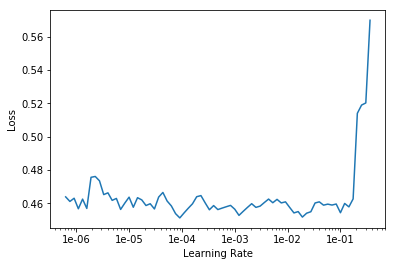

In [92]:
my_learner.lr_find()
my_learner.recorder.plot()

In [50]:
my_learner.get_preds()

[tensor([[0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
         [0.8291, 0.1709],
 

# Fresh model

In [ ]:
classes = (0, 1)

In [ ]:
train_ds[1]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Define weights
zeros = valid_dl.dataset.tensors[1].tolist().count(0)
ones = valid_dl.dataset.tensors[1].tolist().count(1)
total = zeros + ones
weights = torch.tensor([zeros / total, ones / total])

In [ ]:
#Define dataset weights

criterion = nn.CrossEntropyLoss(weight = weights)

batch_size = 30

train_ds = tdatautils.TensorDataset(X,y)
valid_ds = tdatautils.TensorDataset(X_val,y_val)
test_ds = tdatautils.TensorDataset(X_test,y_test)

#Load data
batch_size = 1
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)

#Train on smallest ds: test_ds
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
n_hid = 20
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 405, out_channels=1, kernel_size = 1)
        #self.conv1 = nn.Conv2d(in_channels = 405, out_channels=1, kernel_size = 1)
        self.Relu1 = nn.LeakyReLU()
        self.Linear = nn.Linear(in_features = batch_size*5, out_features = batch_size*2)
        #self.Softmax = 
        
        
    def forward(self, x):
        #print("Before conv", x.shape)
        x = self.conv1(x)
        #print("After conv", x.shape)
        x = self.Relu1(x)
        #set_trace()
        x = x.view(batch_size, 5)
        x = self.Linear(x)
        return x

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    # Train
    model.train()  # IMPORTANT
    running_loss, correct = 0.0, 0
    
    for i, data in enumerate(valid_dl, 1):
        # get the inputs (x, y)
        X, y = data
        print("X", X.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_ = model(X)
        
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
        # Statistics
        #print(f"    batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(y_, 1)
        correct += (y_label_ == y).sum().item()
        running_loss += loss.item() * X.shape[0]
    
    print(f"  Train Loss: {running_loss / len(valid_dl.dataset)}")
    print(f"  Train Acc:  {correct / len(valid_dl.dataset)}")
    
    
    # Eval
    model.eval()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in test_dl:
            #X, y = X.to(DEVICE), y.to(DEVICE)
                    
            y_ = model(X)
        
            # Statistics
            #set_trace()
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
    
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    print()

print('Finished Training')

In [ ]:
correct

In [ ]:
test_dl.dataset.tensors[1]

In [ ]:
test_dl.dataset.tensors[1].tolist().count(0)

In [ ]:
asd

In [ ]:
for X, y in test_dl:
    print("X", X)
    print("y", y)

In [ ]:
net(inputs)

In [ ]:
outputs

In [ ]:
labels

### Analysis

In [ ]:
preds = my_learner.get_preds() #get valdation preds, 256
preds[0]

In [ ]:
#Get raw predictions
raw_yhat = my_learner.get_preds(); yhat

#Find highest multi-class prediction (yes, this is wrong ...)
yhat = []
for i in range(len(raw_yhat[0])):
    pred = raw_yhat[0][i].tolist()
    pred = pred.index(max(pred))
    yhat.append(pred)

#Pairwise comparison
yhat = np.array(yhat)
y_true = np.array(y_val)
preds = yhat==y_true

print("Correct predictions:", sum(preds) / len(preds))
print("Tn, fp, fn, tp")
print(metrics.confusion_matrix(y_true, yhat))
#tn, fp, fn, tp = metrics.confusion_matrix(y_true, yhat).ravel()
#print(tn, fp, fn, tp)

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_true, yhat).ravel()
print(tn, fp, fn, tp)

fpr, tpr, _ = metrics.roc_curve(y_true.ravel(), yhat.ravel())
roc_auc = metrics.auc(fpr, tpr)

#def L1(yHat, y):
#    return (np.sum(np.absolute(yHat - y)**2) / y.size)

#rmse = L1(pred_vec_all, y_test_all)
#mcc = matthews_corrcoef(y_test_all, y_binary)
#avp = average_precision_score(y_true = y_binary, y_score = y_test_all)

In [ ]:
print(tn, fp, fn, tp)

print(roc_auc)

In [ ]:
for yhat, y_true in zip(yhat, y_true):
    print(yhat, y_true)

In [ ]:
np.where(yhat == y_true, 1, 0)[0:10]

In [ ]:
length = len(my_learner.data.valid_ds[:][1])
pred_true = int(sum(my_learner.data.valid_ds[:][1]))
pred_false = length - pred_true
length, pred_true, pred_false

In [ ]:
np.where()

In [ ]:
len(my_learner.data.valid_ds[:][1]) / sum (my_learner.data.valid_ds[:][1])

In [ ]:
len(my_learner.data.valid_ds[:][1])

In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()


### Working model

In [ ]:
!gpustat

In [ ]:
def count_model_params(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [ ]:
batch_size = 1
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)
criterion = nn.CrossEntropyLoss() 

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 405, out_channels = 1, kernel_size = 1)

    def forward(self, x):
        input_size = x.shape[0]
        print("Input", x.shape)
        
        x = self.conv1(x)
        print("After conv:", x.shape)
        x = x.reshape(input_size, 5)
        print("\nEnd:", x.shape)
        print("End:", x)
        return x

print(net)  
print( 'trainable params: {}'.format(count_model_params(net)) )
net = Model().cuda()

my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=accuracy_thresh)
my_learner.fit_one_cycle(1, 5e-02)


In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()


In [ ]:
preds = my_learner.get_preds() #get valdation preds, 256
preds[0]

In [ ]:
np.where(preds[0] >= 0.5, 1, 0)

In [ ]:
my_learner.data.valid_ds[:][1]

In [ ]:
preds = my_learner.get_preds() #get valdation preds, 256
preds[0]

### Continued

In [ ]:
my_learner.save("Stage 0")

In [ ]:
my_learner.fit_one_cycle(5,5e-02)

In [ ]:
my_learner.save("Stage 1")

In [ ]:
my_learner.load("Stage 1")

In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()


### NN test model

In [ ]:
def count_model_params(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1*9, 5)
        self.maxpool = nn.MaxPool1d(kernel_size = 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

net = Net()
print(net)
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

input = torch.randn(1, 9)
input = my_data_bunch.train_ds[0][0]
out = net(input)
print(out.shape)
print(out)
print(input.shape)

In [ ]:
my_learner.fit_one_cycle(10,1e-1)


In [ ]:
batch_size = 1
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)

criterion = nn.CrossEntropyLoss() # NLL + Log_softmax layer = multi-class Cross-entropy

class Net(nn.Module):
    def __init__(self, input_size=(1*9), hidden_size=9, num_classes=1):
        super(Net, self).__init__()
        self.fc_0 = nn.Linear(input_size, hidden_size)
        self.relu_0 = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size,hidden_size)        
        self.relu_1 = nn.ReLU()
        self.last = nn.Linear(hidden_size,num_classes)
        self.log_softmax_layer = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.fc_0(x)
        out = self.relu_1(self.fc_0(out))
        out = self.last(out)
        print(out.shape)
        #out = self.log_softmax_layer(out)
        out = self.log_softmax_layer(out)
        #out = out.flatten()
        print(out.shape)
        print(out)
        return out
    
#create instance of model
net = Net(input_size=(1*9),hidden_size=9,num_classes=1).cuda()
print(net)  
print( 'trainable params: {}'.format(count_model_params(net)) )

my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion)
my_learner.fit_one_cycle(1,1e-1)

In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()


In [ ]:
my_learner.fit_one_cycle(1,1e-1)

In [ ]:
out.flatten().shape

In [ ]:
my_data_bunch.train_ds[0][0].shape

In [ ]:
# pool of size=3, stride=2
m = nn.MaxPool1d(50, stride=1)
input = torch.randn(20, 16, 50)
output = m(input)
output

### 2.b Class definition of model

In [ ]:
y.shape

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size=(9), hidden_size=9, num_classes=3):
        super(Net, self).__init__()
        self.fc_0 = nn.Linear(input_size, hidden_size) 
        self.relu_0 = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size,hidden_size)        
        self.relu_1 = nn.ReLU()
        self.last = nn.Linear(hidden_size,num_classes)
        self.log_softmax_layer = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.relu_0(self.fc_0(x))
        out = self.relu_1(self.fc_1(out))
        out = self.log_softmax_layer(self.last(out))
        
        return out
    
#create instance of model
net = Net(input_size=(1),hidden_size=9,num_classes=3).cuda()
print(net)  
print( 'trainable params: {}'.format(count_model_params(net)) )

## 3. Build Learner

In [ ]:
my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion)

#### From here we can use the learner just like any other Fast.ai learner

In [ ]:
my_learner.lr_find()

In [ ]:
my_learner.recorder.plot()

In [ ]:
my_learner.fit_one_cycle(1,1e-1)

In [ ]:
plt.plot(my_learner.recorder.losses[::batch_size]) #losses for each batch.  Take at end of epoch only
plt.plot(my_learner.recorder.val_losses)

In [ ]:
X

In [ ]:
y